In [2]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#komentarze ze względu na wygodę będą prowadzone po polsku

In [3]:
#wczytanie danych z plików wejściowych
audiots = scipy.io.loadmat('DATA\DREGON_free-flight_speech-high_room1_audiots.mat') 
sourcepos = scipy.io.loadmat('DATA\DREGON_free-flight_speech-high_room1_sourcepos.mat')["source_position"]
rate, data = scipy.io.wavfile.read('DATA\DREGON_free-flight_speech-high_room1.wav')

#zapisanie danych do wektorów
audio_timestamps=audiots["audio_timestamps"]
timestamps=sourcepos["timestamps"][0,0]
azimuth=sourcepos["azimuth"][0,0]
elevation=sourcepos["elevation"][0,0]
distance=sourcepos["distance"][0,0]

In [4]:
elevation_for_data=np.zeros((data.shape[0],1))
azimuth_for_data=np.zeros((data.shape[0],1))
j=0
l=0
for i in range(0,timestamps.size):
    l=l+j
    j=0
    while not(np.isclose(timestamps[i],audio_timestamps[l+j],rtol=0,atol=1e-4)==True):
        if (i+l+j>audio_timestamps.size):
            print("break")
            break
        else:
            j=j+1
    else:
        elevation_for_data[l+j]=elevation[i,0]
        azimuth_for_data[l+j]=azimuth[i,0]
        if i % 500==0:
            print(i)
#timestamps_step=timestamps_step.astype(int)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [5]:
data_cut=data[226095:,:]
elevation_for_data_cut=elevation_for_data[226095:]
azimuth_for_data_cut=azimuth_for_data[226095:]
print(data.shape)
print(elevation_for_data.shape)
print(azimuth_for_data.shape)
print(data_cut.shape)
print(elevation_for_data_cut.shape)
print(azimuth_for_data_cut.shape)

(2348538, 8)
(2348538, 1)
(2348538, 1)
(2122443, 8)
(2122443, 1)
(2122443, 1)


In [6]:
elevation_data=np.zeros((96,1))
azimuth_data=np.zeros((96,1))
k=0
l=0
m=0
for i in range(0,96):
    k=0
    l=0
    m=0
    for j in range(0,22050):
        k=k+elevation_for_data_cut[i*22050+j]
        l=l+azimuth_for_data_cut[i*22050+j]
        if j>0:
            m=m+1
    elevation_data[i]=k/m
    azimuth_data[i]=l/m


In [7]:
#podział danych na zbiór uczący, walidacyjny i testowy

input=data_cut[0:60*22050,:]
input_val=data_cut[60*22050:80*22050,:]
input_test=data_cut[80*22050:96*22050,:]

output=elevation_data[0:60,0]
output_val=elevation_data[60:80,0]
output_test=elevation_data[80:96,:]

print(input.shape)
print(input_val.shape)
print(input_test.shape)
print(output.shape)
print(output_val.shape)
print(output_test.shape)

(1323000, 8)
(441000, 8)
(352800, 8)
(60,)
(20,)
(16, 1)


In [8]:
print(input_test.shape)

(352800, 8)


In [9]:
def prepare_input(input):
  input_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input, None, sequence_length=300)
  for batch in input_dataset:
    inputs = batch
    assert np.array_equal(inputs[0], input[:300]) 
    break
  return(input_dataset)

input_train0=tf.reshape(input,[60,22050,8])
input_val0=tf.reshape(input_val,[20,22050,8])
input_test0=tf.reshape(input_test,[16,22050,8])

output0=tf.reshape(output,[output.size,1])
output_val0=tf.reshape(output_val,[output_val.size,1])
output_test0=tf.reshape(output_test,[output_test.size,1])

In [10]:
from keras.models import Model
from keras.layers import Dense, Conv1D, MaxPooling1D , GlobalMaxPooling1D, GlobalMaxPooling2D, BatchNormalization, Dropout, Input, concatenate


input1 = Input(shape=(22050,8))

DCNN = Conv1D(filters=32, kernel_size=21, dilation_rate=1, activation='relu')(input1)
DCNN = BatchNormalization()(DCNN)
DCNN = Conv1D(filters=64, kernel_size=19, dilation_rate=2, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = MaxPooling1D(pool_size=3)(DCNN)
DCNN = Conv1D(filters=128, kernel_size=17, dilation_rate=3, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = Conv1D(filters=256, kernel_size=15, dilation_rate=5, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = MaxPooling1D(pool_size=2)(DCNN)
DCNN = Conv1D(filters=512, kernel_size=13, dilation_rate=8, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = Conv1D(filters=1024, kernel_size=11, dilation_rate=13, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = MaxPooling1D(pool_size=2)(DCNN)
DCNN = Conv1D(filters=1024, kernel_size=9, dilation_rate=21, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = Conv1D(filters=1024, kernel_size=7, dilation_rate=34, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)
DCNN = MaxPooling1D(pool_size=2)(DCNN)
DCNN = Conv1D(filters=1024, kernel_size=7, dilation_rate=55, activation='relu')(DCNN)
DCNN = BatchNormalization()(DCNN)

z = GlobalMaxPooling1D()(DCNN)
z = Dropout(0.5)(z)
z = Dropout(0.5)(z)
z = Dense(512, activation='relu')(z)
z = BatchNormalization()(z)
z = Dense(1, activation="linear")(z)

model = Model(input1, z)




In [11]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22050, 8)]        0         
                                                                 
 conv1d (Conv1D)             (None, 22030, 32)         5408      
                                                                 
 batch_normalization (BatchN  (None, 22030, 32)        128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 21994, 64)         38976     
                                                                 
 batch_normalization_1 (Batc  (None, 21994, 64)        256       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7331, 64)         0     

In [12]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 100
opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(loss='mse',loss_weights=4.,metrics='mae', optimizer=opt)

C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
from keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

train_input=input_train0
train_output=output0
valid_input=input_val0
valid_output=output_val0
history = model.fit(train_input,train_output,validation_data=(valid_input, valid_output),epochs=100,callbacks=callbacks)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 7.2690 - mae: 1.0810   

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 211s/step - loss: 7.2690 - mae: 1.0810 - val_loss: 1.1865 - val_mae: 0.5431
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 8.5949 - mae: 1.0859  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 210s/step - loss: 8.5949 - mae: 1.0859 - val_loss: 0.9470 - val_mae: 0.4853
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 7.5058 - mae: 1.1104   

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 209s/step - loss: 7.5058 - mae: 1.1104 - val_loss: 0.7303 - val_mae: 0.4261
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 9.3651 - mae: 1.1786   

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 210s/step - loss: 9.3651 - mae: 1.1786 - val_loss: 0.9904 - val_mae: 0.4961
Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 5.3138 - mae: 0.8675  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 210s/step - loss: 5.3138 - mae: 0.8675 - val_loss: 1.2055 - val_mae: 0.5473
Epoch 6/100
2/2 [==============================] - ETA: 0s - loss: 7.3111 - mae: 1.0367  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 413s 210s/step - loss: 7.3111 - mae: 1.0367 - val_loss: 1.3526 - val_mae: 0.5796
Epoch 7/100
2/2 [==============================] - ETA: 0s - loss: 8.1972 - mae: 1.1156  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 414s 211s/step - loss: 8.1972 - mae: 1.1156 - val_loss: 1.3466 - val_mae: 0.5780
Epoch 8/100
2/2 [==============================] - ETA: 0s - loss: 9.2736 - mae: 1.0950  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 414s 211s/step - loss: 9.2736 - mae: 1.0950 - val_loss: 1.1316 - val_mae: 0.5297
Epoch 9/100
2/2 [==============================] - ETA: 0s - loss: 7.6107 - mae: 1.0102  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 411s 208s/step - loss: 7.6107 - mae: 1.0102 - val_loss: 0.9405 - val_mae: 0.4827
Epoch 10/100
2/2 [==============================] - ETA: 0s - loss: 6.7849 - mae: 0.9437  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 411s 209s/step - loss: 6.7849 - mae: 0.9437 - val_loss: 0.6841 - val_mae: 0.4120
Epoch 11/100
2/2 [==============================] - ETA: 0s - loss: 5.9873 - mae: 0.9637  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 207s/step - loss: 5.9873 - mae: 0.9637 - val_loss: 0.4630 - val_mae: 0.3393
Epoch 12/100
2/2 [==============================] - ETA: 0s - loss: 6.6727 - mae: 0.9963  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 6.6727 - mae: 0.9963 - val_loss: 0.3297 - val_mae: 0.2862
Epoch 13/100
2/2 [==============================] - ETA: 0s - loss: 5.7485 - mae: 0.9231  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 413s 209s/step - loss: 5.7485 - mae: 0.9231 - val_loss: 0.3155 - val_mae: 0.2797
Epoch 14/100
2/2 [==============================] - ETA: 0s - loss: 5.9346 - mae: 0.9379  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 5.9346 - mae: 0.9379 - val_loss: 0.3430 - val_mae: 0.2915
Epoch 15/100
2/2 [==============================] - ETA: 0s - loss: 6.3272 - mae: 0.9738  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 207s/step - loss: 6.3272 - mae: 0.9738 - val_loss: 0.3228 - val_mae: 0.2826
Epoch 16/100
2/2 [==============================] - ETA: 0s - loss: 4.6450 - mae: 0.8664  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 4.6450 - mae: 0.8664 - val_loss: 0.3054 - val_mae: 0.2747
Epoch 17/100
2/2 [==============================] - ETA: 0s - loss: 5.6473 - mae: 0.9655  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 5.6473 - mae: 0.9655 - val_loss: 0.2772 - val_mae: 0.2618
Epoch 18/100
2/2 [==============================] - ETA: 0s - loss: 4.8990 - mae: 0.8803  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 409s 207s/step - loss: 4.8990 - mae: 0.8803 - val_loss: 0.2439 - val_mae: 0.2455
Epoch 19/100
2/2 [==============================] - ETA: 0s - loss: 4.6687 - mae: 0.8445  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 409s 209s/step - loss: 4.6687 - mae: 0.8445 - val_loss: 0.1894 - val_mae: 0.2151
Epoch 20/100
2/2 [==============================] - ETA: 0s - loss: 5.9659 - mae: 0.9304  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 5.9659 - mae: 0.9304 - val_loss: 0.1870 - val_mae: 0.2130
Epoch 21/100
2/2 [==============================] - ETA: 0s - loss: 3.7234 - mae: 0.8014  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 3.7234 - mae: 0.8014 - val_loss: 0.2101 - val_mae: 0.2268
Epoch 22/100
2/2 [==============================] - ETA: 0s - loss: 6.3365 - mae: 0.9536  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 411s 208s/step - loss: 6.3365 - mae: 0.9536 - val_loss: 0.2261 - val_mae: 0.2362
Epoch 23/100
2/2 [==============================] - ETA: 0s - loss: 4.1094 - mae: 0.8439  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 4.1094 - mae: 0.8439 - val_loss: 0.2635 - val_mae: 0.2553
Epoch 24/100
2/2 [==============================] - ETA: 0s - loss: 3.9850 - mae: 0.7712  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 410s 207s/step - loss: 3.9850 - mae: 0.7712 - val_loss: 0.3019 - val_mae: 0.2724
Epoch 25/100
2/2 [==============================] - ETA: 0s - loss: 3.9965 - mae: 0.7885  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 3.9965 - mae: 0.7885 - val_loss: 0.3352 - val_mae: 0.2850
Epoch 26/100
2/2 [==============================] - ETA: 0s - loss: 3.4384 - mae: 0.6998  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 411s 208s/step - loss: 3.4384 - mae: 0.6998 - val_loss: 0.3407 - val_mae: 0.2851
Epoch 27/100
2/2 [==============================] - ETA: 0s - loss: 4.7708 - mae: 0.9020  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 4.7708 - mae: 0.9020 - val_loss: 0.3007 - val_mae: 0.2656
Epoch 28/100
2/2 [==============================] - ETA: 0s - loss: 3.8925 - mae: 0.8054  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 3.8925 - mae: 0.8054 - val_loss: 0.2595 - val_mae: 0.2448
Epoch 29/100
2/2 [==============================] - ETA: 0s - loss: 3.1823 - mae: 0.7027  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 3.1823 - mae: 0.7027 - val_loss: 0.2153 - val_mae: 0.2219
Epoch 30/100
2/2 [==============================] - ETA: 0s - loss: 5.1872 - mae: 0.8173  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 207s/step - loss: 5.1872 - mae: 0.8173 - val_loss: 0.1839 - val_mae: 0.2049
Epoch 31/100
2/2 [==============================] - ETA: 0s - loss: 4.6774 - mae: 0.8439  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 207s/step - loss: 4.6774 - mae: 0.8439 - val_loss: 0.1679 - val_mae: 0.1961
Epoch 32/100
2/2 [==============================] - ETA: 0s - loss: 3.1672 - mae: 0.7108  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 3.1672 - mae: 0.7108 - val_loss: 0.1516 - val_mae: 0.1855
Epoch 33/100
2/2 [==============================] - ETA: 0s - loss: 3.8737 - mae: 0.7547  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 207s/step - loss: 3.8737 - mae: 0.7547 - val_loss: 0.1203 - val_mae: 0.1642
Epoch 34/100
2/2 [==============================] - ETA: 0s - loss: 3.6228 - mae: 0.7334  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 3.6228 - mae: 0.7334 - val_loss: 0.1122 - val_mae: 0.1587
Epoch 35/100
2/2 [==============================] - ETA: 0s - loss: 3.3339 - mae: 0.7470  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.3339 - mae: 0.7470 - val_loss: 0.1300 - val_mae: 0.1728
Epoch 36/100
2/2 [==============================] - ETA: 0s - loss: 3.0372 - mae: 0.7082  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 411s 207s/step - loss: 3.0372 - mae: 0.7082 - val_loss: 0.1518 - val_mae: 0.1890
Epoch 37/100
2/2 [==============================] - ETA: 0s - loss: 5.3136 - mae: 0.8512  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 5.3136 - mae: 0.8512 - val_loss: 0.1645 - val_mae: 0.1982
Epoch 38/100
2/2 [==============================] - ETA: 0s - loss: 5.7021 - mae: 0.9959  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 5.7021 - mae: 0.9959 - val_loss: 0.1576 - val_mae: 0.1947
Epoch 39/100
2/2 [==============================] - ETA: 0s - loss: 2.1499 - mae: 0.5837  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 416s 211s/step - loss: 2.1499 - mae: 0.5837 - val_loss: 0.1367 - val_mae: 0.1817
Epoch 40/100
2/2 [==============================] - ETA: 0s - loss: 3.4445 - mae: 0.7238  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 409s 208s/step - loss: 3.4445 - mae: 0.7238 - val_loss: 0.1430 - val_mae: 0.1870
Epoch 41/100
2/2 [==============================] - ETA: 0s - loss: 5.6736 - mae: 0.8784  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 5.6736 - mae: 0.8784 - val_loss: 0.1756 - val_mae: 0.2079
Epoch 42/100
2/2 [==============================] - ETA: 0s - loss: 4.4991 - mae: 0.8134  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 409s 207s/step - loss: 4.4991 - mae: 0.8134 - val_loss: 0.1921 - val_mae: 0.2175
Epoch 43/100
2/2 [==============================] - ETA: 0s - loss: 3.8585 - mae: 0.7633  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.8585 - mae: 0.7633 - val_loss: 0.2199 - val_mae: 0.2334
Epoch 44/100
2/2 [==============================] - ETA: 0s - loss: 3.9901 - mae: 0.8013  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.9901 - mae: 0.8013 - val_loss: 0.2871 - val_mae: 0.2670
Epoch 45/100
2/2 [==============================] - ETA: 0s - loss: 2.7647 - mae: 0.6781  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 413s 208s/step - loss: 2.7647 - mae: 0.6781 - val_loss: 0.3028 - val_mae: 0.2743
Epoch 46/100
2/2 [==============================] - ETA: 0s - loss: 3.2255 - mae: 0.6925  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 408s 208s/step - loss: 3.2255 - mae: 0.6925 - val_loss: 0.3203 - val_mae: 0.2823
Epoch 47/100
2/2 [==============================] - ETA: 0s - loss: 4.3869 - mae: 0.8389  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 409s 207s/step - loss: 4.3869 - mae: 0.8389 - val_loss: 0.3221 - val_mae: 0.2832
Epoch 48/100
2/2 [==============================] - ETA: 0s - loss: 2.8266 - mae: 0.6651  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 405s 207s/step - loss: 2.8266 - mae: 0.6651 - val_loss: 0.2599 - val_mae: 0.2543
Epoch 49/100
2/2 [==============================] - ETA: 0s - loss: 2.6710 - mae: 0.6456  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.6710 - mae: 0.6456 - val_loss: 0.2720 - val_mae: 0.2602
Epoch 50/100
2/2 [==============================] - ETA: 0s - loss: 4.3097 - mae: 0.8475  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 4.3097 - mae: 0.8475 - val_loss: 0.3065 - val_mae: 0.2762
Epoch 51/100
2/2 [==============================] - ETA: 0s - loss: 2.8435 - mae: 0.6976  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.8435 - mae: 0.6976 - val_loss: 0.3537 - val_mae: 0.2966
Epoch 52/100
2/2 [==============================] - ETA: 0s - loss: 3.0678 - mae: 0.7054  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 3.0678 - mae: 0.7054 - val_loss: 0.4022 - val_mae: 0.3162
Epoch 53/100
2/2 [==============================] - ETA: 0s - loss: 3.3378 - mae: 0.7022  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 3.3378 - mae: 0.7022 - val_loss: 0.4840 - val_mae: 0.3468
Epoch 54/100
2/2 [==============================] - ETA: 0s - loss: 3.1515 - mae: 0.7259  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.1515 - mae: 0.7259 - val_loss: 0.5233 - val_mae: 0.3602
Epoch 55/100
2/2 [==============================] - ETA: 0s - loss: 2.4333 - mae: 0.5934  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 209s/step - loss: 2.4333 - mae: 0.5934 - val_loss: 0.6375 - val_mae: 0.3969
Epoch 56/100
2/2 [==============================] - ETA: 0s - loss: 3.8292 - mae: 0.7612  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 3.8292 - mae: 0.7612 - val_loss: 0.6599 - val_mae: 0.4028
Epoch 57/100
2/2 [==============================] - ETA: 0s - loss: 3.5631 - mae: 0.7357  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 3.5631 - mae: 0.7357 - val_loss: 0.7359 - val_mae: 0.4254
Epoch 58/100
2/2 [==============================] - ETA: 0s - loss: 3.7845 - mae: 0.7837  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.7845 - mae: 0.7837 - val_loss: 0.7615 - val_mae: 0.4331
Epoch 59/100
2/2 [==============================] - ETA: 0s - loss: 3.1752 - mae: 0.7277  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.1752 - mae: 0.7277 - val_loss: 0.7607 - val_mae: 0.4335
Epoch 60/100
2/2 [==============================] - ETA: 0s - loss: 3.2374 - mae: 0.7109  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 3.2374 - mae: 0.7109 - val_loss: 0.8451 - val_mae: 0.4578
Epoch 61/100
2/2 [==============================] - ETA: 0s - loss: 2.9698 - mae: 0.6073  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 214s/step - loss: 2.9698 - mae: 0.6073 - val_loss: 0.9241 - val_mae: 0.4793
Epoch 62/100
2/2 [==============================] - ETA: 0s - loss: 2.9866 - mae: 0.6893  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.9866 - mae: 0.6893 - val_loss: 0.9103 - val_mae: 0.4759
Epoch 63/100
2/2 [==============================] - ETA: 0s - loss: 2.6508 - mae: 0.6434  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 413s 215s/step - loss: 2.6508 - mae: 0.6434 - val_loss: 0.8915 - val_mae: 0.4711
Epoch 64/100
2/2 [==============================] - ETA: 0s - loss: 2.5660 - mae: 0.6095  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.5660 - mae: 0.6095 - val_loss: 0.9392 - val_mae: 0.4836
Epoch 65/100
2/2 [==============================] - ETA: 0s - loss: 3.9578 - mae: 0.7152  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 410s 208s/step - loss: 3.9578 - mae: 0.7152 - val_loss: 0.9455 - val_mae: 0.4852
Epoch 66/100
2/2 [==============================] - ETA: 0s - loss: 2.2191 - mae: 0.5651  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.2191 - mae: 0.5651 - val_loss: 0.8133 - val_mae: 0.4498
Epoch 67/100
2/2 [==============================] - ETA: 0s - loss: 2.3819 - mae: 0.5886  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.3819 - mae: 0.5886 - val_loss: 0.7423 - val_mae: 0.4292
Epoch 68/100
2/2 [==============================] - ETA: 0s - loss: 2.2355 - mae: 0.6116  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.2355 - mae: 0.6116 - val_loss: 0.6703 - val_mae: 0.4072
Epoch 69/100
2/2 [==============================] - ETA: 0s - loss: 3.7135 - mae: 0.7406  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 3.7135 - mae: 0.7406 - val_loss: 0.6276 - val_mae: 0.3936
Epoch 70/100
2/2 [==============================] - ETA: 0s - loss: 2.3018 - mae: 0.5927  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.3018 - mae: 0.5927 - val_loss: 0.5684 - val_mae: 0.3743
Epoch 71/100
2/2 [==============================] - ETA: 0s - loss: 3.1893 - mae: 0.7265  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 3.1893 - mae: 0.7265 - val_loss: 0.5039 - val_mae: 0.3525
Epoch 72/100
2/2 [==============================] - ETA: 0s - loss: 2.7070 - mae: 0.6472  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 410s 208s/step - loss: 2.7070 - mae: 0.6472 - val_loss: 0.4801 - val_mae: 0.3447
Epoch 73/100
2/2 [==============================] - ETA: 0s - loss: 3.3132 - mae: 0.7211  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.3132 - mae: 0.7211 - val_loss: 0.4534 - val_mae: 0.3354
Epoch 74/100
2/2 [==============================] - ETA: 0s - loss: 2.5108 - mae: 0.6570  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.5108 - mae: 0.6570 - val_loss: 0.4795 - val_mae: 0.3450
Epoch 75/100
2/2 [==============================] - ETA: 0s - loss: 3.0210 - mae: 0.6955  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.0210 - mae: 0.6955 - val_loss: 0.5097 - val_mae: 0.3559
Epoch 76/100
2/2 [==============================] - ETA: 0s - loss: 2.5673 - mae: 0.5953  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.5673 - mae: 0.5953 - val_loss: 0.6236 - val_mae: 0.3939
Epoch 77/100
2/2 [==============================] - ETA: 0s - loss: 2.2985 - mae: 0.6251  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.2985 - mae: 0.6251 - val_loss: 0.8512 - val_mae: 0.4606
Epoch 78/100
2/2 [==============================] - ETA: 0s - loss: 2.4669 - mae: 0.6369  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 207s/step - loss: 2.4669 - mae: 0.6369 - val_loss: 1.0745 - val_mae: 0.5177
Epoch 79/100
2/2 [==============================] - ETA: 0s - loss: 2.5866 - mae: 0.6420  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.5866 - mae: 0.6420 - val_loss: 1.1573 - val_mae: 0.5373
Epoch 80/100
2/2 [==============================] - ETA: 0s - loss: 2.1314 - mae: 0.5714  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.1314 - mae: 0.5714 - val_loss: 1.1351 - val_mae: 0.5320
Epoch 81/100
2/2 [==============================] - ETA: 0s - loss: 2.5329 - mae: 0.5962  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 413s 214s/step - loss: 2.5329 - mae: 0.5962 - val_loss: 1.0644 - val_mae: 0.5151
Epoch 82/100
2/2 [==============================] - ETA: 0s - loss: 4.1905 - mae: 0.8208  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 405s 208s/step - loss: 4.1905 - mae: 0.8208 - val_loss: 0.9270 - val_mae: 0.4807
Epoch 83/100
2/2 [==============================] - ETA: 0s - loss: 2.3498 - mae: 0.6328  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.3498 - mae: 0.6328 - val_loss: 0.7989 - val_mae: 0.4462
Epoch 84/100
2/2 [==============================] - ETA: 0s - loss: 2.2860 - mae: 0.6105  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.2860 - mae: 0.6105 - val_loss: 0.7234 - val_mae: 0.4245
Epoch 85/100
2/2 [==============================] - ETA: 0s - loss: 2.2598 - mae: 0.5973  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 413s 215s/step - loss: 2.2598 - mae: 0.5973 - val_loss: 0.6665 - val_mae: 0.4074
Epoch 86/100
2/2 [==============================] - ETA: 0s - loss: 1.9402 - mae: 0.5571  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 1.9402 - mae: 0.5571 - val_loss: 0.6784 - val_mae: 0.4108
Epoch 87/100
2/2 [==============================] - ETA: 0s - loss: 2.9437 - mae: 0.6734  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.9437 - mae: 0.6734 - val_loss: 0.7613 - val_mae: 0.4350
Epoch 88/100
2/2 [==============================] - ETA: 0s - loss: 4.1016 - mae: 0.7125  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 405s 207s/step - loss: 4.1016 - mae: 0.7125 - val_loss: 0.9481 - val_mae: 0.4852
Epoch 89/100
2/2 [==============================] - ETA: 0s - loss: 2.2847 - mae: 0.6191  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.2847 - mae: 0.6191 - val_loss: 1.1028 - val_mae: 0.5233
Epoch 90/100
2/2 [==============================] - ETA: 0s - loss: 2.6011 - mae: 0.6612  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 414s 214s/step - loss: 2.6011 - mae: 0.6612 - val_loss: 1.1135 - val_mae: 0.5256
Epoch 91/100
2/2 [==============================] - ETA: 0s - loss: 2.5531 - mae: 0.6160  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.5531 - mae: 0.6160 - val_loss: 1.0575 - val_mae: 0.5119
Epoch 92/100
2/2 [==============================] - ETA: 0s - loss: 1.4130 - mae: 0.4691  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 1.4130 - mae: 0.4691 - val_loss: 1.0706 - val_mae: 0.5148
Epoch 93/100
2/2 [==============================] - ETA: 0s - loss: 1.9061 - mae: 0.5556  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 412s 214s/step - loss: 1.9061 - mae: 0.5556 - val_loss: 1.0666 - val_mae: 0.5135
Epoch 94/100
2/2 [==============================] - ETA: 0s - loss: 2.4672 - mae: 0.6254  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 2.4672 - mae: 0.6254 - val_loss: 1.1088 - val_mae: 0.5237
Epoch 95/100
2/2 [==============================] - ETA: 0s - loss: 3.0555 - mae: 0.7330  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 407s 208s/step - loss: 3.0555 - mae: 0.7330 - val_loss: 1.1488 - val_mae: 0.5335
Epoch 96/100
2/2 [==============================] - ETA: 0s - loss: 2.7697 - mae: 0.6047  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 207s/step - loss: 2.7697 - mae: 0.6047 - val_loss: 0.9588 - val_mae: 0.4873
Epoch 97/100
2/2 [==============================] - ETA: 0s - loss: 3.9803 - mae: 0.7723  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 405s 207s/step - loss: 3.9803 - mae: 0.7723 - val_loss: 0.7849 - val_mae: 0.4407
Epoch 98/100
2/2 [==============================] - ETA: 0s - loss: 2.4526 - mae: 0.5791  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.4526 - mae: 0.5791 - val_loss: 0.6231 - val_mae: 0.3925
Epoch 99/100
2/2 [==============================] - ETA: 0s - loss: 2.8515 - mae: 0.6854  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.8515 - mae: 0.6854 - val_loss: 0.4730 - val_mae: 0.3413
Epoch 100/100
2/2 [==============================] - ETA: 0s - loss: 2.5950 - mae: 0.6120  

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 406s 208s/step - loss: 2.5950 - mae: 0.6120 - val_loss: 0.4082 - val_mae: 0.3167


In [16]:
#model.save(args["model"], save_format="h5")
model.save('saved_models', save_format="h5")

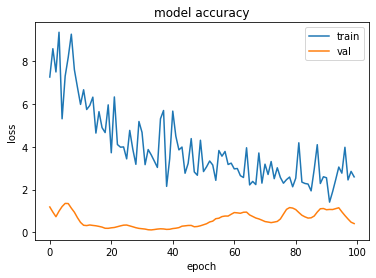

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [32]:
from tensorflow import keras
loaded_model=keras.models.load_model("saved_models")
test_input=input_test0
test_output=output_test0

test_predict = model.predict(test_input)

1/1 [==============================] - 19s 19s/step


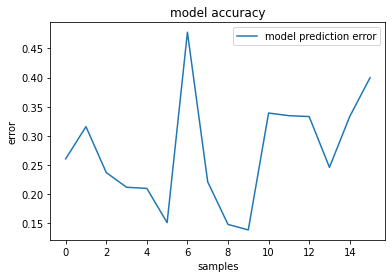

In [33]:
plt.plot(test_predict-test_output)
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('samples')
plt.legend(["model prediction error"], loc='upper right')
plt.show()